In [1]:
%%time
import pyfesom2 as pf
import xarray as xr
import numpy as np
import h5netcdf

import glob
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd
import gc
import shutil
import os
import matplotlib.tri as mtri
import cmocean
from datetime import datetime, date, timedelta 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import griddata

from dask.distributed import Client
import dask
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status'})

osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.
CPU times: user 5.11 s, sys: 5.47 s, total: 10.6 s
Wall time: 11.6 s


In [2]:
%matplotlib inline  

In [3]:
#paths 
data_path = '/p/scratch/chhb19/mueller29/AO_40_nopc/'
obs_path = '/p/scratch/chhb19/mueller29/sea_ice/'
noaa_path = '/p/scratch/chhb19/mueller29/sea_ice/sea_ice_NOAA/'

mesh_path = '/p/project/chhb19/meshes/AO_40/'
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/ice_maps/'
out_path = '/p/scratch/chhb19/mueller29/maps/'

In [4]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [62]:
n_cores = 5
mem_lim = str(int(np.floor(95/n_cores)))+'GB'
if 'client' in locals() or 'client' in globals():
    client.close()
client = Client(n_workers=n_cores, threads_per_worker=1,memory_limit=mem_lim)
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Workers: 5
Total threads: 5,Total memory: 88.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39519,Workers: 5
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/8787/status,Total threads: 5
Started: Just now,Total memory: 88.48 GiB
Comm: tcp://127.0.0.1:43391,Total threads: 1
Dashboard: /user/vasco.mueller_at_awi.de/r0b111d10d9c453583df569be68e9959/proxy/41199/status,Memory: 17.70 GiB
Nanny: tcp://127.0.0.1:46641,


In [5]:
# chunk sizes
horizontal_split = 1000000
vertical_split = 1
time_split = 1

In [6]:
mesh = pf.load_mesh(mesh_path)

/p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/meshes/AO_40/pickle_mesh_py3_fesom2


In [8]:
file_list_amsr = []
file_list_model = []
file_list_noaa = []

for yy in np.arange(2015,2021):    
    file_list_amsr.append(sorted(glob.glob(obs_path+str(yy)+'/*.nc')))
    file_list_model.append(data_path+'a_ice_monthly.fesom.' + str(yy) + '.nc')
    file_list_noaa.append(sorted(glob.glob(noaa_path+'*'+str(yy)+'*.nc')))
file_list_amsr=sum(file_list_amsr,[]) 
file_list_noaa=sum(file_list_noaa,[]) 


In [9]:
ice_model_all=xr.open_mfdataset(file_list_model,chunks={'time':1})['a_ice'].astype('float32')

In [10]:
ice_model_all

<xarray.DataArray 'a_ice' (time: 72, nod2: 11538465)>
dask.array<concatenate, shape=(72, 11538465), dtype=float32, chunksize=(1, 11538465), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-16T23:58:00 ... 2020-12-16T23:58:00
Dimensions without coordinates: nod2
Attributes:
    long_name:     ice concentration
    units:         %
    cell_methods:  time: mean
    description:   ice concentration

In [65]:
ice_era5_all=xr.open_dataset(('/p/scratch/chhb19/mueller29/sea_ice_era5.nc'),chunks={'time':1})['siconc'].astype('float32')
ice_era5_all = ice_era5_all.isel(time=(ice_era5_all.time.dt.year>=2015)&(ice_era5_all.time.dt.year<=2020))

In [66]:
ice_noaa_all = xr.open_mfdataset(file_list_noaa,combine='nested',concat_dim='tdim',chunks={'time':1})['cdr_seaice_conc_monthly'].astype('float32')
ice_noaa_all = xr.where(ice_noaa_all<=1, ice_noaa_all, np.nan)

In [67]:
coords = xr.open_dataset((obs_path+'LongitudeLatitudeGrid-n6250-Arctic.hdf'),engine='netcdf4')
coords = coords.rename_dims({'fakeDim0': 'y', 'fakeDim1': 'x','fakeDim2': 'y', 'fakeDim3': 'x'})


noaa_x = ice_noaa_all.xgrid.values
noaa_y = ice_noaa_all.ygrid.values

xx,yy = np.meshgrid(noaa_x,noaa_y)

from pyproj import Transformer
transformer = Transformer.from_crs( "EPSG:3411","EPSG:4326")
lat_noaa, lon_noaa = transformer.transform(xx, yy)



In [31]:
for mon in np.arange(1,13):
    date_string = '_mean_'+str(mon).zfill(2) 

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        #select month
        ice_model = ice_model_all[ice_model_all.time.dt.month==mon,:].mean(dim='time').values
        ice_era5 = ice_era5_all[ice_era5_all.time.dt.month==mon,:,:].squeeze().mean(dim='time').values
        ice_noaa = ice_noaa_all[ice_noaa_all.time.dt.month==mon,:,:].squeeze().mean(dim='tdim').values

    gridded_file = out_path+'a_ice_gridded_'+date_string+'.npz'


    # define euler angles
    alpha = -90
    beta = 90
    gamma = 90

    # region
    left = -180
    right = 180
    south = 65
    north = 90


    if not os.path.exists(gridded_file):
        # load mesh and rotate to equator
        elements = mesh.elem.astype("int32")
        lons = mesh.x2
        lats = mesh.y2


        lons_rot, lats_rot = pf.ut.scalar_g2r(alpha, beta, gamma, lons,lats)
        d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
        no_cyclic_elem = np.argwhere(d < 100).ravel()
        points_rot = np.vstack((lons_rot, lats_rot)).T

        # regular grid at equator for interpolation

        dx = 0.1
        dy = 0.1    

        nx2 = (
            north - south + dx
        )  # just to make sure the grid isn't square (makes it easier to keep track of dimensions)
        ny2 = north - south
        lon_reg = np.arange(-nx2, nx2, dx)
        lat_reg = np.arange(-ny2, ny2, dy)
        xx_eq, yy_eq = np.meshgrid(lon_reg, lat_reg)
        xx_eq = xx_eq.T
        yy_eq = yy_eq.T
        xx_pol, yy_pol = pf.ut.scalar_r2g(
            alpha, beta, gamma, xx_eq, yy_eq
        ) 

        if 'triang' not in locals():
            triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])
            tri = triang.get_trifinder()

        ice_model_grid = mtri.LinearTriInterpolator(triang, ice_model, trifinder=tri)(xx_eq, yy_eq)
        #save stuff
        np.savez_compressed(gridded_file,xx_pol=xx_pol, yy_pol=yy_pol,ice_model_grid=ice_model_grid)
    else:
        gridded_stuff = np.load(gridded_file)
        xx_pol = gridded_stuff['xx_pol']
        yy_pol = gridded_stuff['yy_pol']
        ice_model_grid = gridded_stuff['ice_model_grid']  

    xx_era,yy_era=np.meshgrid(ice_era5_all.longitude,ice_era5_all.latitude)
    xx_rot, yy_rot = pf.ut.scalar_g2r(alpha, beta, gamma, xx_era,yy_era)
    xx_eq, yy_eq = pf.ut.scalar_g2r(alpha, beta, gamma, xx_pol,yy_pol)
    gridded_data = griddata((xx_rot.ravel(),yy_rot.ravel()), ice_era5.ravel(), (xx_eq, yy_eq), method='linear',fill_value=np.nan)



    figsize = (5, 20) #1/4 page

    fig, axs = plt.subplots(
                1,
                3,
                subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
                constrained_layout=True,
                figsize=figsize,
            )
    axs_fl = axs.flatten()

    ax = axs_fl[0]    
    ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    image = ax.pcolormesh(lon_noaa,lat_noaa,100*ice_noaa, cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    ax.set_title('NOAA')


    ax = axs_fl[1]
    ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    image = ax.pcolormesh(xx_pol, yy_pol, 100*gridded_data , cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    ax.set_title('ERA5')


    ax = axs_fl[2]
    ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    image = ax.pcolormesh(xx_pol, yy_pol, 100*ice_model_grid , cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
    ax.set_title('FESOM2')



    cb = fig.colorbar(image, orientation="horizontal", ax=axs, pad=0.01, shrink=0.85, extend='neither')
    cb.ax.tick_params(labelsize=15)
    cb.set_label('sea ice conc. [%]', size=15)

    fig.savefig((plot_path + '/a_ice_comparison'+date_string+'.png'), dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')
    plt.close(fig)

In [68]:
for yy in np.arange(2015,2021):
    for mon in np.arange(1,13):
        #date_string = '_mean_'+str(yy)+str(mon).zfill(2) 
        date_string = datetime.strptime(str(yy) + "-" + str(mon), "%Y-%m").strftime("%Y_%m") 
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            #select month
            ice_model = ice_model_all[(ice_model_all.time.dt.month==mon)&(ice_model_all.time.dt.year==yy),:].squeeze().values
            ice_era5 = ice_era5_all[(ice_era5_all.time.dt.month==mon)&(ice_era5_all.time.dt.year==yy),:,:].squeeze().values
            ice_noaa = ice_noaa_all[(ice_noaa_all.time.dt.month==mon)&(ice_noaa_all.time.dt.year==yy),:,:].squeeze().values 
        gridded_file = out_path+'a_ice_gridded_'+date_string+'.npz'


        # define euler angles
        alpha = -90
        beta = 90
        gamma = 90

        # region
        left = -180
        right = 180
        south = 65
        north = 90


        if not os.path.exists(gridded_file):
            # load mesh and rotate to equator
            elements = mesh.elem.astype("int32")
            lons = mesh.x2
            lats = mesh.y2


            lons_rot, lats_rot = pf.ut.scalar_g2r(alpha, beta, gamma, lons,lats)
            d = lons_rot[elements].max(axis=1) - lons_rot[elements].min(axis=1)
            no_cyclic_elem = np.argwhere(d < 100).ravel()
            points_rot = np.vstack((lons_rot, lats_rot)).T

            # regular grid at equator for interpolation

            dx = 0.1
            dy = 0.1    

            nx2 = (
                north - south + dx
            )  # just to make sure the grid isn't square (makes it easier to keep track of dimensions)
            ny2 = north - south
            lon_reg = np.arange(-nx2, nx2, dx)
            lat_reg = np.arange(-ny2, ny2, dy)
            xx_eq, yy_eq = np.meshgrid(lon_reg, lat_reg)
            xx_eq = xx_eq.T
            yy_eq = yy_eq.T
            xx_pol, yy_pol = pf.ut.scalar_r2g(
                alpha, beta, gamma, xx_eq, yy_eq
            ) 

            if 'triang' not in locals():
                triang = mtri.Triangulation(lons_rot, lats_rot, elements[no_cyclic_elem])
                tri = triang.get_trifinder()

            ice_model_grid = mtri.LinearTriInterpolator(triang, ice_model, trifinder=tri)(xx_eq, yy_eq)
            #save stuff
            np.savez_compressed(gridded_file,xx_pol=xx_pol, yy_pol=yy_pol,ice_model_grid=ice_model_grid)
        else:
            gridded_stuff = np.load(gridded_file)
            xx_pol = gridded_stuff['xx_pol']
            yy_pol = gridded_stuff['yy_pol']
            ice_model_grid = gridded_stuff['ice_model_grid']  

        xx_era,yy_era=np.meshgrid(ice_era5_all.longitude,ice_era5_all.latitude)
        xx_rot, yy_rot = pf.ut.scalar_g2r(alpha, beta, gamma, xx_era,yy_era)
        xx_eq, yy_eq = pf.ut.scalar_g2r(alpha, beta, gamma, xx_pol,yy_pol)
        gridded_data = griddata((xx_rot.ravel(),yy_rot.ravel()), ice_era5.ravel(), (xx_eq, yy_eq), method='linear',fill_value=np.nan)



        figsize = (5, 20) #1/4 page

        fig, axs = plt.subplots(
                    1,
                    3,
                    subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
                    constrained_layout=True,
                    figsize=figsize,
                )
        axs_fl = axs.flatten()

        ax = axs_fl[0]    
        ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='50m')
        image = ax.pcolormesh(lon_noaa,lat_noaa,100*ice_noaa, cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
        ax.set_title('NOAA')


        ax = axs_fl[1]
        ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='50m')
        image = ax.pcolormesh(xx_pol, yy_pol, 100*gridded_data , cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
        ax.set_title('ERA5')


        ax = axs_fl[2]
        ax.set_extent([-180,180,70,90], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='50m')
        image = ax.pcolormesh(xx_pol, yy_pol, 100*ice_model_grid , cmap = cmocean.cm.ice, vmin=0, vmax=100, shading='auto',transform=ccrs.PlateCarree())
        ax.set_title('FESOM2')



        cb = fig.colorbar(image, orientation="horizontal", ax=axs, pad=0.01, shrink=0.85, extend='neither')
        cb.ax.tick_params(labelsize=15)
        cb.set_label('sea ice conc. [%]', size=15)

        fig.savefig((plot_path + '/a_ice_comparison'+date_string+'.png'), dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')
        plt.close(fig)

In [104]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of the Earth in meters
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

def grid_quadrangle_surface_area(latitudes, longitudes):
    num_rows, num_cols = latitudes.shape
    areas = np.zeros((num_rows - 1, num_cols - 1))
    
    for i in range(num_rows - 1):
        for j in range(num_cols - 1):
            lat1, lon1 = latitudes[i, j], longitudes[i, j]
            lat2, lon2 = latitudes[i + 1, j], longitudes[i + 1, j]
            lat3, lon3 = latitudes[i + 1, j + 1], longitudes[i + 1, j + 1]
            lat4, lon4 = latitudes[i, j + 1], longitudes[i, j + 1]
            
            d1 = haversine_distance(lat1, lon1, lat2, lon2)
            d2 = haversine_distance(lat2, lon2, lat3, lon3)
            d3 = haversine_distance(lat3, lon3, lat4, lon4)
            d4 = haversine_distance(lat4, lon4, lat1, lon1)
            
            # Calculate area using Heron's formula

            s = (d1 + d2 + d3 + d4) / 2
            areas[i, j] = np.sqrt((s - d1) * (s - d2) * (s - d3) * (s - d4))
    
    return areas

import numpy.matlib as npm


In [198]:
lat = ice_era5_all.latitude.values
lon = ice_era5_all.longitude.values

dlat = np.diff(lat).mean()
longitude_vec = lon[0:2]
latitude_vec = np.append(lat-dlat/2,65.)
lon2 ,lat2 = np.meshgrid(longitude_vec,latitude_vec)


tmp = grid_quadrangle_surface_area(lat2,lon2)
grid_cell_areas_era5 = np.tile(tmp, (72, 1, len(lon)))

ice_cover = (ice_era5_all>0.15).values
ice_ext_era5 = np.sum(grid_cell_areas_era5*ice_cover,axis=(1,2))/1e12

In [199]:
ice_cover = (ice_noaa_all[:,:-1,:-1]>0.15).values #doesn't matter, only zeros cut off
grid_cell_areas_noaa = grid_quadrangle_surface_area(lat_noaa,lon_noaa)
ice_ext_noaa = np.sum(grid_cell_areas_noaa*ice_cover,axis=(1,2))/1e12

In [200]:
ice_cover = ((ice_model_all>0.15)&(mesh.y2>0)).values
grid_cell_areas_model = np.tile(mesh.lump2,(72,1))
ice_ext_model = np.sum(grid_cell_areas_model*ice_cover,axis=1)/1e12

In [281]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 3

In [282]:
def minmax(time_series_data):
    data_per_year = time_series_data.reshape(-1, 12)

    # Calculate annual minima and maxima
    
    annual_minima = np.min(data_per_year, axis=1)
    index_minima = np.argmin(data_per_year, axis=1)
    annual_maxima = np.max(data_per_year, axis=1)
    index_maxima = np.argmax(data_per_year, axis=1)
    
    
    boolean_array = np.zeros_like(data_per_year, dtype=bool)
    for year, idx in enumerate(index_minima):
        boolean_array[year, idx] = True
    index_minima = boolean_array.ravel()
    boolean_array = np.zeros_like(data_per_year, dtype=bool)
    for year, idx in enumerate(index_maxima):
        boolean_array[year, idx] = True
    index_maxima = boolean_array.ravel() 
    
    return annual_minima,annual_maxima,index_minima,index_maxima

In [283]:
min_noaa,max_noaa,min_noaa_ind,max_noaa_ind = minmax(ice_ext_noaa)
min_era5,max_era5,min_era5_ind,max_era5_ind = minmax(ice_ext_era5)
min_model,max_model,min_model_ind,max_model_ind = minmax(ice_ext_model)


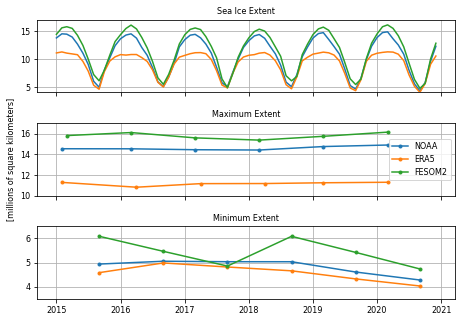

In [285]:
cm2in = 1/2.54  # centimeters in inches
figsize = (19*cm2in, 11.5*cm2in) #1/2 page
fig, axs = plt.subplots(
            3,
            1,
            figsize=(figsize),
            sharex = True
        )

ax = axs[0]
ax.plot(ice_noaa_all.time,ice_ext_noaa,label='NOAA')
ax.plot(ice_noaa_all.time,ice_ext_era5,label='ERA5')
ax.plot(ice_noaa_all.time,ice_ext_model,label='FESOM2')
ax.set_ylim([4, 17])
ax.grid()
ax.set_title('Sea Ice Extent',fontsize=SMALL_SIZE)

ax = axs[1]
ind = (ice_noaa_all.time.dt.month == 3).values
ax.plot(ice_noaa_all.time[max_noaa_ind],max_noaa,label='NOAA',marker='o')
ax.plot(ice_noaa_all.time[max_era5_ind],max_era5,label='ERA5',marker='o')
ax.plot(ice_noaa_all.time[max_model_ind],max_model,label='FESOM2',marker='o')
ax.set_ylim([10, 17])
ax.set_yticks(np.arange(10,18,2))
ax.grid()
ax.set_title('Maximum Extent',fontsize=SMALL_SIZE)
#ax.set_ylabel('[$10^6 km^2$]')
ax.set_ylabel('[millions of square kilometers]')

ax.legend(loc='center right',fontsize=SMALL_SIZE)

ax = axs[2]
ind = (ice_noaa_all.time.dt.month == 9).values
ax.plot(ice_noaa_all.time[min_noaa_ind],min_noaa,label='NOAA',marker='o')
ax.plot(ice_noaa_all.time[min_era5_ind],min_era5,label='ERA5',marker='o')
ax.plot(ice_noaa_all.time[min_model_ind],min_model,label='FESOM2',marker='o')
ax.set_ylim([3.5, 6.5])
ax.set_yticks(np.arange(4,7,1))
ax.grid()
ax.set_title('Minimum Extent',fontsize=SMALL_SIZE)



for d in range(1,3):
    chartBox = axs[d].get_position()
    axs[d].set_position([chartBox.x0, #adjust vertical positions
        chartBox.y0-d*.05,
        chartBox.width,
        chartBox.height])     

fig.savefig((plot_path + '/ice_extent.png'), dpi=400, format='png',bbox_inches='tight',pad_inches=0,facecolor='white')